**By Hamilton Hitchings, Dec 3rd, 2020**

For Imperial College London's Online Class: Getting Started with TensorFlow 2

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.backend import one_hot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, \
    Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
from google.colab import drive # Load the Drive helper and mount

drive.mount('/content/drive') # This will prompt for authorization

Mounted at /content/drive


In [ ]:
train = loadmat('/content/drive/My Drive/SVHN/train_32x32.mat')
test = loadmat('/content/drive/My Drive/SVHN/test_32x32.mat')

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
# Extract the training and testing images and labels separately from the train and 
# test dictionaries loaded for you.

train_X = np.array(train['X']).astype('float64') / 255.0 # Scale to 0 - 1.0
num_train_elements = train_X.shape[3]
train_X = np.moveaxis(train_X, -1, 0) # Move the last dimension to the first

train_y_sparse = np.array(train['y'])
train_y_sparse = train_y_sparse.reshape((num_train_elements)) # Remove nested dimension
# train_y = one_hot(train_y, 10)
train_y = to_categorical(train_y_sparse, 11) # Convert to one hot encoding
train_y = train_y[:,1:] # Remove 0th column since categories are 1 - 10

test_X = np.array(test['X']).astype('float64') / 255.0 # Scale to 0 - 1.0
num_test_elements = test_X.shape[3]
test_X = np.moveaxis(test_X, -1, 0) # Move the last dimension to the first

test_y_sparse = np.array(test['y'])
test_y_sparse = test_y_sparse.reshape((num_test_elements)) # Remove nested dimension
test_y = to_categorical(test_y_sparse, 11) # Convert to one hot encoding
test_y = test_y[:,1:] # Remove 0th column since categories are 1 - 10

print(f'Number of training samples = {num_train_elements}, Number of test samples = {num_test_elements}')

print(f"train_X.shape={train_X.shape}, train_y.shape={train_y.shape}")
print(f"test_X.shape={test_X.shape}, test_y.shape={test_y.shape}")

print(f"first test result {test_y_sparse[0]}, one hot encoded {test_y[0]}")

Number of training samples = 73257, Number of test samples = 26032
train_X.shape=(73257, 32, 32, 3), train_y.shape=(73257, 10)
test_X.shape=(26032, 32, 32, 3), test_y.shape=(26032, 10)
first test result 5, one hot encoded [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
def print_label(y_label):
    m = 1
    for n in y_label:
        if n == 1:
            print(f"Label {m}")
        m += 1

In [ ]:
# Select a random sample of images and 
# corresponding labels from the dataset 
# (at least 10), and display them in a figure.

def print_random_samples(num_samples, data_X, 
                         data_y, data_y_sparse):

    num_elements = data_y.shape[0]
    for i in range(0,num_samples):
        n = random.randint(1,num_elements-1)
        img = data_X[n, :, :, :]
        print(f"Sample {n}, Label {data_y_sparse[n]}")
        if img.shape[2] == 1:
            plt.imshow(img[:, :, 0], cmap='gray')
        else:
            plt.imshow(img)
        plt.show()

Sample 20892, Label 4


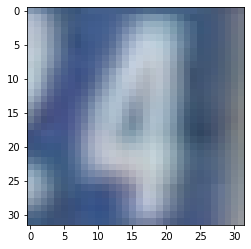

Sample 66891, Label 2


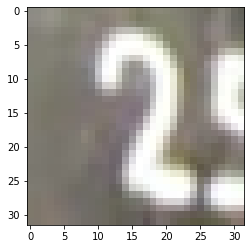

Sample 44690, Label 1


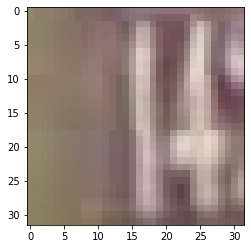

Sample 29359, Label 3


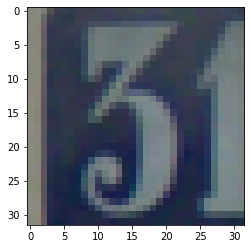

Sample 46527, Label 4


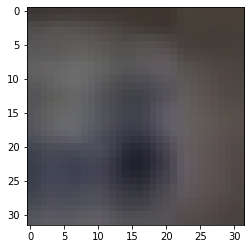

Sample 41892, Label 7


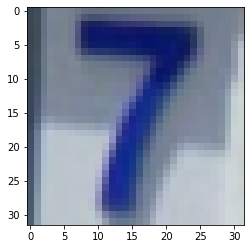

Sample 53615, Label 2


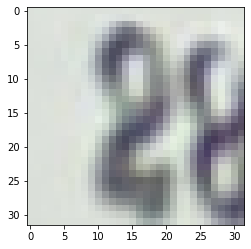

Sample 50697, Label 7


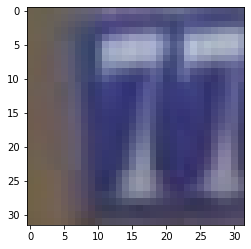

Sample 57992, Label 5


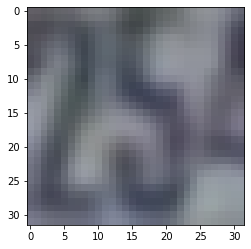

Sample 32295, Label 1


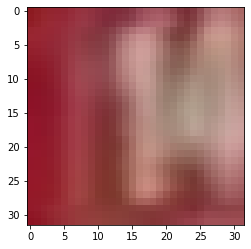

In [ ]:
#@title
print_random_samples(10, train_X, train_y, train_y_sparse)

In [ ]:
def transform_data(in_data_X, in_data_y, num_elements):
    res_X = np.full((num_elements, 32, 32, 1), 0.0)

    i = 0
    while i < num_elements:
        img = in_data_X[i, :, :, :]
        img_gray = np.mean(img, axis=2,keepdims=1)
        res_X[i] = img_gray
        i += 1

    return res_X, in_data_y

(train_X, train_y) = transform_data(train_X, train_y, num_train_elements)
(test_X, test_y) = transform_data(test_X, test_y, num_test_elements)

train_X.shape

(73257, 32, 32, 1)

Sample 57311, Label 2


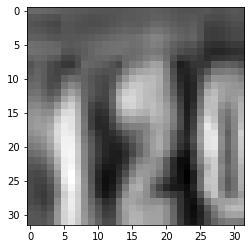

Sample 69612, Label 1


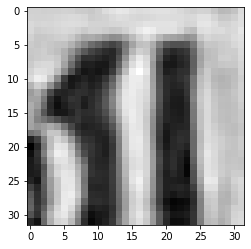

Sample 57272, Label 5


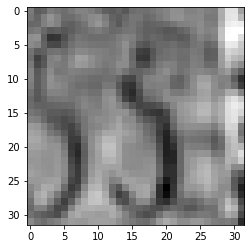

Sample 46085, Label 6


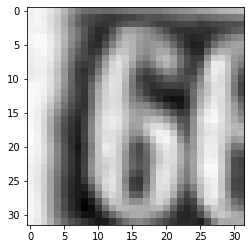

Sample 7566, Label 8


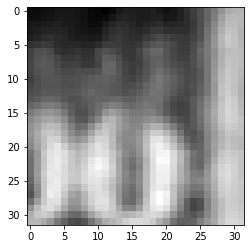

Sample 10350, Label 1


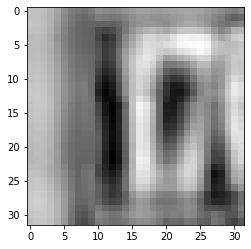

Sample 29127, Label 3


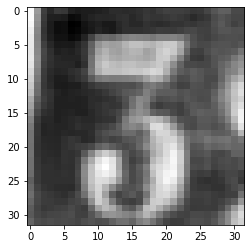

Sample 27142, Label 2


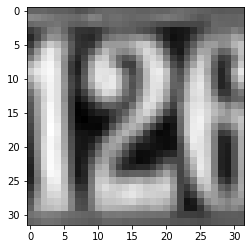

Sample 58542, Label 4


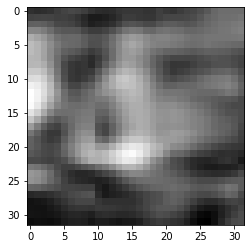

Sample 34812, Label 3


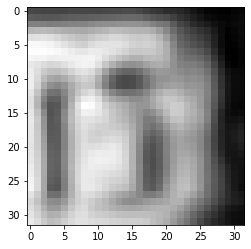

In [ ]:
#@title
# Select a random sample of the grayscale images and corresponding 
# labels from the dataset (at least 10), and display them in a 
# figure.

print_random_samples(10, train_X, train_y, train_y_sparse)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
# An MLP classifier model using the Sequential API. 
# Only Flatten and Dense layers (4 layers), with the final layer having a 10-way softmax output.
# Prints model summary

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax, Input

model = Sequential([
    Flatten(input_shape=(32,32,1), name="layer_1"),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005), name="layer_2"),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005), name="layer_3"),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005), name="layer_4"),
    Dense(10, activation='softmax', name="output_layer")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Flatten)            (None, 1024)              0         
_________________________________________________________________
layer_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
layer_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
layer_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
output_layer (Dense)         (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile and train the model with 30 epochs and include validation sets using mae

model.compile(optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy', 'mae'])

In [ ]:
# Create 3 callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback, Callback, ReduceLROnPlateau

best_model_checkpoint = ModelCheckpoint('best_model', 
                             save_weights_only=True,
                             save_best_only=True, 
                             monitor='accuracy')

early_stopping_callback = EarlyStopping(monitor='accuracy', patience=6)

# Ended up not using this callback
epoch_end_callback = LambdaCallback(
    on_epoch_end=lambda epoch,logs: print(f" Epoch {epoch} done."))

# Ended up not using this callback
# learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.2, verbose=1)

In [ ]:
history = model.fit(train_X, train_y, batch_size=128, validation_split=0.15, epochs=30,
                   callbacks=[best_model_checkpoint, early_stopping_callback], verbose=2)

Epoch 1/30
487/487 - 2s - loss: 2.2514 - accuracy: 0.2152 - mae: 0.1735 - val_loss: 2.1174 - val_accuracy: 0.2491 - val_mae: 0.1685
Epoch 2/30
487/487 - 2s - loss: 1.9726 - accuracy: 0.3238 - mae: 0.1593 - val_loss: 1.8108 - val_accuracy: 0.4026 - val_mae: 0.1510
Epoch 3/30
487/487 - 2s - loss: 1.5845 - accuracy: 0.4743 - mae: 0.1352 - val_loss: 1.4726 - val_accuracy: 0.5217 - val_mae: 0.1261
Epoch 4/30
487/487 - 2s - loss: 1.3894 - accuracy: 0.5566 - mae: 0.1202 - val_loss: 1.4055 - val_accuracy: 0.5608 - val_mae: 0.1162
Epoch 5/30
487/487 - 2s - loss: 1.2929 - accuracy: 0.6005 - mae: 0.1108 - val_loss: 1.2602 - val_accuracy: 0.6217 - val_mae: 0.1087
Epoch 6/30
487/487 - 2s - loss: 1.2299 - accuracy: 0.6318 - mae: 0.1045 - val_loss: 1.2037 - val_accuracy: 0.6390 - val_mae: 0.1024
Epoch 7/30
487/487 - 2s - loss: 1.1726 - accuracy: 0.6552 - mae: 0.0990 - val_loss: 1.1539 - val_accuracy: 0.6632 - val_mae: 0.0977
Epoch 8/30
487/487 - 2s - loss: 1.1292 - accuracy: 0.6731 - mae: 0.0944 - va

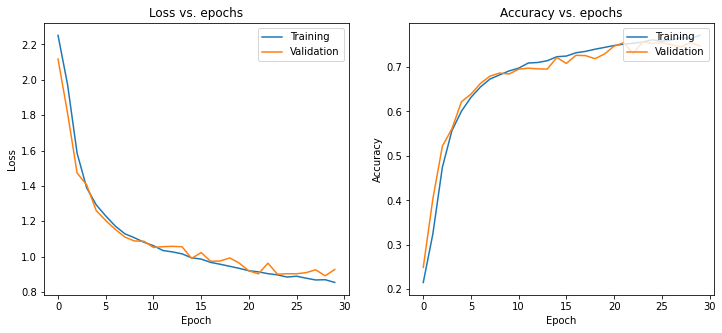

In [ ]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch 
# for both training and validation sets.

def plot_learning_curves():
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')

    fig.add_subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()
    
plot_learning_curves()

In [ ]:
# Compute and display the loss and accuracy of the trained model on the test set.

model.evaluate(test_X, test_y, verbose=2)

814/814 - 2s - loss: 1.0199 - accuracy: 0.7240 - mae: 0.0747


[1.0198639631271362, 0.7239551544189453, 0.07473725080490112]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 1), padding='SAME', name = 'conv_1'),
    MaxPooling2D((2,2), name='pool_1'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='SAME', name = 'conv_2'), 
    MaxPooling2D((2,2), name='pool_2'),
    Dropout(0.3),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', input_shape=(32, 32, 1), padding='SAME', name = 'conv_3'),
    MaxPooling2D((2,2), name='pool_3'),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu', name='dense_1'),
    Dropout(0.3),
    Dense(10, activation='softmax', name='dense_2')
])

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 64)         

In [ ]:
# Compile and train the model with 30 epochs and include validation sets using mae

model_cnn.compile(optimizer=Adam(),
      loss='categorical_crossentropy',
      metrics=['accuracy', 'mae'])

history = model_cnn.fit(train_X, train_y, batch_size=256, 
        validation_split=0.15, epochs=30, verbose=2,
        callbacks=[best_model_checkpoint, early_stopping_callback])

Epoch 1/30
244/244 - 3s - loss: 1.9059 - accuracy: 0.3215 - mae: 0.1546 - val_loss: 2.3392 - val_accuracy: 0.1881 - val_mae: 0.1748
Epoch 2/30
244/244 - 2s - loss: 1.1718 - accuracy: 0.5897 - mae: 0.1047 - val_loss: 1.9661 - val_accuracy: 0.2983 - val_mae: 0.1618
Epoch 3/30
244/244 - 2s - loss: 0.8722 - accuracy: 0.7064 - mae: 0.0794 - val_loss: 0.9499 - val_accuracy: 0.7322 - val_mae: 0.0938
Epoch 4/30
244/244 - 2s - loss: 0.7114 - accuracy: 0.7687 - mae: 0.0651 - val_loss: 0.4656 - val_accuracy: 0.8720 - val_mae: 0.0478
Epoch 5/30
244/244 - 2s - loss: 0.6160 - accuracy: 0.8070 - mae: 0.0558 - val_loss: 0.4256 - val_accuracy: 0.8756 - val_mae: 0.0409
Epoch 6/30
244/244 - 2s - loss: 0.5484 - accuracy: 0.8321 - mae: 0.0491 - val_loss: 0.5540 - val_accuracy: 0.8437 - val_mae: 0.0569
Epoch 7/30
244/244 - 2s - loss: 0.5040 - accuracy: 0.8485 - mae: 0.0448 - val_loss: 0.3829 - val_accuracy: 0.8872 - val_mae: 0.0357
Epoch 8/30
244/244 - 2s - loss: 0.4619 - accuracy: 0.8602 - mae: 0.0411 - va

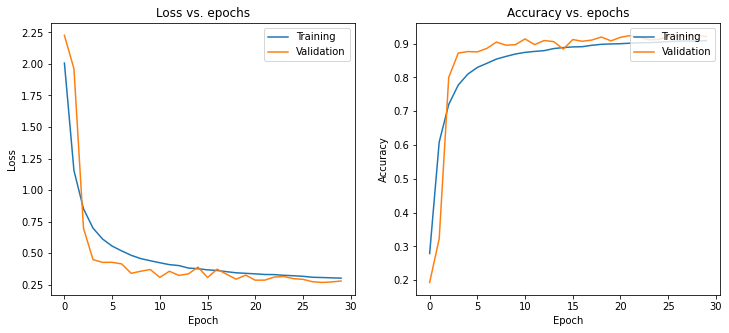

In [ ]:
#@title
plot_learning_curves()

In [ ]:
model_cnn.evaluate(test_X, test_y, verbose=2)

814/814 - 2s - loss: 0.2795 - accuracy: 0.9241 - mae: 0.0264


[0.27951207756996155, 0.9241318106651306, 0.026370378211140633]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
model_cnn.load_weights('best_model')

In [ ]:
# Randomly select 5 images and corresponding labels from the test set and display 
# the images with their labels.
# Alongside the image and label, show each model’s predictive distribution as a 
# bar chart, and the final model prediction given by the label with maximum probability.

def print_random_samples(num_samples, data_X, data_y, data_y_sparse):

    random_index = np.random.choice(data_X.shape[0], num_samples)
    random_test_images = data_X[random_index, ...]
    random_test_labels = data_y_sparse[random_index, ...]
    predictions = model_cnn.predict(random_test_images)

    for i in range(0, num_samples):
        img = random_test_images[i]
        label = random_test_labels[i]
        prediction = predictions[i]
        pred_label = prediction.argmax() + 1
        pred_prob = prediction[pred_label - 1]
        print(f"Test Sample with Label {label}")

        fig = plt.figure(figsize=(12, 5))

        fig.add_subplot(121)
        plt.imshow(img[:, :, 0], cmap='gray')

        ax2 = fig.add_subplot(122)
        ax2.set_xticks(np.arange(len(prediction)+1))

        plt.bar(list(range(1,11)), prediction, color='blue')
        # plt.hist(prediction, bins=10, histtype='bar', rwidth=0.8)

        plt.xlabel('Digits')
        plt.ylabel('Prediction Weights')
        plt.title(f"Predicted {pred_label} with Probability {pred_prob:0.2f} for Label {label}")
        plt.show()


Test Sample with Label 5


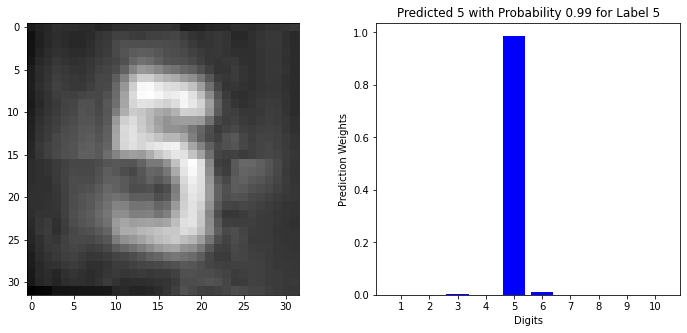

Test Sample with Label 3


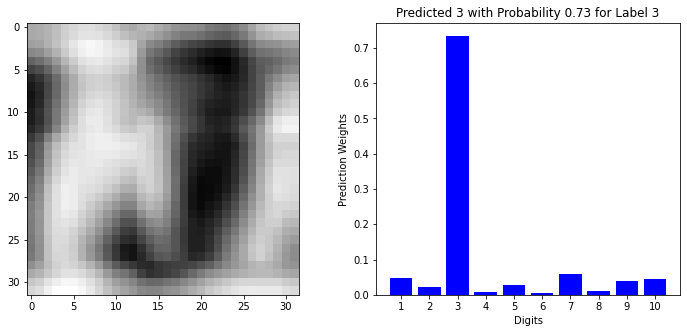

Test Sample with Label 7


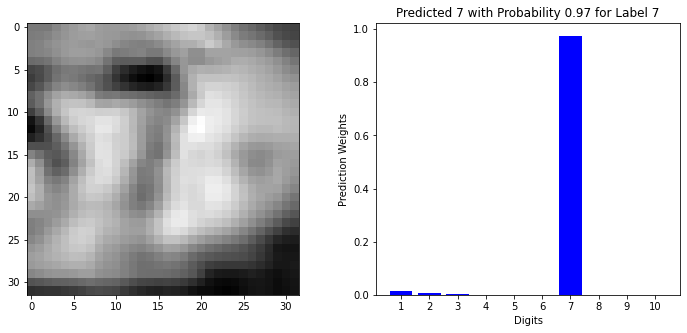

Test Sample with Label 4


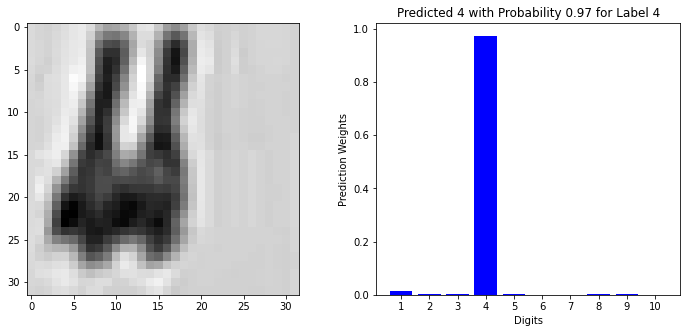

Test Sample with Label 4


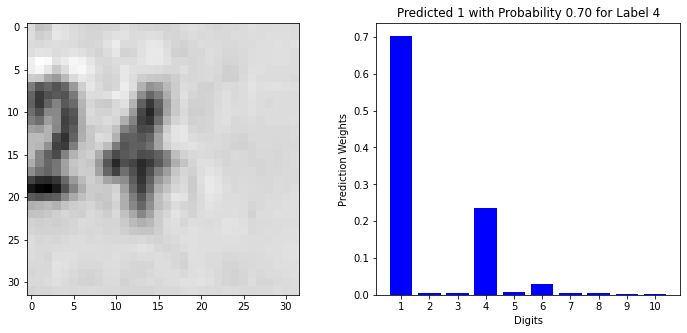

In [ ]:
#@title
print_random_samples(5, test_X, test_y, test_y_sparse)